In [ ]:
import os
import random
import time
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)


Device: cpu


In [ ]:
IMAGE_EXT = (".jpg", ".jpeg", ".png")

def scan_leaf_folders(root):
    class_to_images = {}
    class_id = 0

    for root_dir, subdirs, files in os.walk(root):
        images = [f for f in files if f.lower().endswith(IMAGE_EXT)]


        if images:
            has_child_images = False
            for sd in subdirs:
                sd_path = os.path.join(root_dir, sd)
                if any(
                    f.lower().endswith(IMAGE_EXT)
                    for f in os.listdir(sd_path)
                ):
                    has_child_images = True
                    break

            if not has_child_images and len(images) >= 2:
                class_to_images[class_id] = [
                    os.path.join(root_dir, f) for f in images
                ]
                class_id += 1

    return class_to_images


In [ ]:
DATASET_ROOT = "/content"
class_to_images = scan_leaf_folders(DATASET_ROOT)

print("Total classes:", len(class_to_images))


Total classes: 192


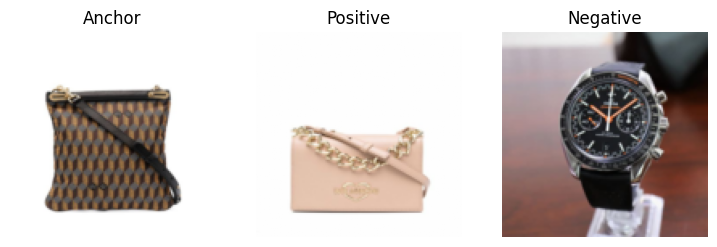

In [ ]:
dataset = TripletDataset(class_to_images)
a, p, n = dataset[0]

plt.figure(figsize=(9,3))
plt.subplot(1,3,1); plt.imshow(a.permute(1,2,0)); plt.title("Anchor"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(p.permute(1,2,0)); plt.title("Positive"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(n.permute(1,2,0)); plt.title("Negative"); plt.axis("off")
plt.show()


In [ ]:
import os, random, time
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)


Device: cpu


In [ ]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])


In [ ]:
class EmbeddingNet(nn.Module):
    def __init__(self):
        super().__init__()
        base = models.mobilenet_v2(weights="IMAGENET1K_V1")
        self.backbone = base.features
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(1280, 128)

    def forward(self, x):
        x = self.backbone(x)
        x = self.pool(x).squeeze(-1).squeeze(-1)
        x = self.fc(x)
        return nn.functional.normalize(x)


In [ ]:
model = EmbeddingNet().to(device)
print("Model initialized")


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 120MB/s]

Model initialized


In [ ]:
criterion = nn.TripletMarginLoss(margin=1.0)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [ ]:
class TripletDataset(Dataset):
    def __init__(self, class_to_images):
        self.class_to_images = class_to_images
        self.classes = list(class_to_images.keys())

    def __len__(self):
        return 1000   # limit for speed

    def __getitem__(self, idx):
        c = random.choice(self.classes)
        a, p = random.sample(self.class_to_images[c], 2)

        neg_c = random.choice([x for x in self.classes if x != c])
        n = random.choice(self.class_to_images[neg_c])

        return (
            transform(Image.open(a).convert("RGB")),
            transform(Image.open(p).convert("RGB")),
            transform(Image.open(n).convert("RGB"))
        )

dataset = TripletDataset(class_to_images)

loader = DataLoader(
    dataset,
    batch_size=16,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)


In [ ]:
model.train()
start = time.time()

for epoch in range(1):
    total_loss = 0

    for i, (a, p, n) in enumerate(loader):
        a, p, n = a.to(device), p.to(device), n.to(device)

        loss = criterion(model(a), model(p), model(n))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if i == 50:
            break

    print("Epoch 1 Loss:", total_loss / (i+1))

print("Training time (seconds):", time.time() - start)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1 Loss: 0.6513127339821235
Training time (seconds): 364.7976884841919


In [ ]:
model.eval()

image_paths = []
embeddings = []

with torch.no_grad():
    for cls in class_to_images:
        for img_path in class_to_images[cls][:5]:  # limit per class
            img = Image.open(img_path).convert("RGB")
            img = transform(img).unsqueeze(0).to(device)

            emb = model(img).cpu().numpy()[0]
            embeddings.append(emb)
            image_paths.append(img_path)

import numpy as np
embeddings = np.array(embeddings)

print("Embeddings shape:", embeddings.shape)


Embeddings shape: (958, 128)


In [ ]:
query_image_path = "/content/drive/MyDrive/fashion/women/footwears/10269.jpg"


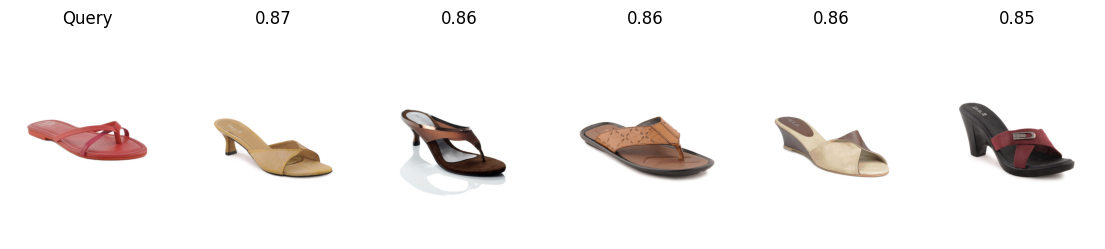

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity


query_image_path = "/content/drive/MyDrive/fashion/women/footwears/10269.jpg"


q_img = Image.open(query_image_path).convert("RGB")
q_tensor = transform(q_img).unsqueeze(0).to(device)


model.eval()
with torch.no_grad():
    q_emb = model(q_tensor).cpu().numpy()


similarities = cosine_similarity(q_emb, embeddings)[0]
top5_idx = similarities.argsort()[::-1][1:6]


plt.figure(figsize=(14,4))

plt.subplot(1,6,1)
plt.imshow(q_img)
plt.title("Query")
plt.axis("off")

for i, idx in enumerate(top5_idx):
    plt.subplot(1,6,i+2)
    plt.imshow(Image.open(image_paths[idx]))
    plt.title(f"{similarities[idx]:.2f}")
    plt.axis("off")

plt.show()


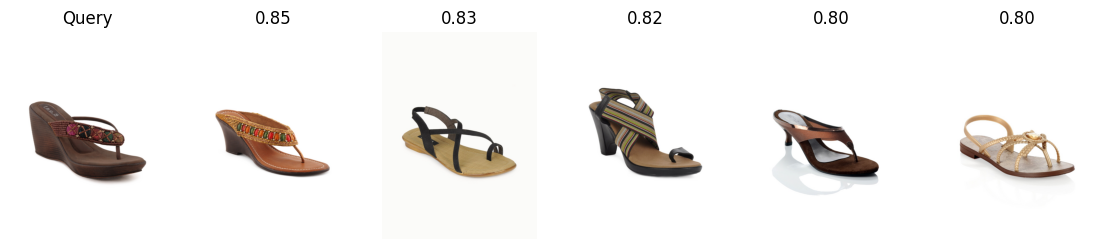

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity


query_image_path = "/content/drive/MyDrive/fashion/women/footwears/13016.jpg"


q_img = Image.open(query_image_path).convert("RGB")
q_tensor = transform(q_img).unsqueeze(0).to(device)


model.eval()
with torch.no_grad():
    q_emb = model(q_tensor).cpu().numpy()


similarities = cosine_similarity(q_emb, embeddings)[0]
top5_idx = similarities.argsort()[::-1][1:6]


plt.figure(figsize=(14,4))

plt.subplot(1,6,1)
plt.imshow(q_img)
plt.title("Query")
plt.axis("off")

for i, idx in enumerate(top5_idx):
    plt.subplot(1,6,i+2)
    plt.imshow(Image.open(image_paths[idx]))
    plt.title(f"{similarities[idx]:.2f}")
    plt.axis("off")

plt.show()


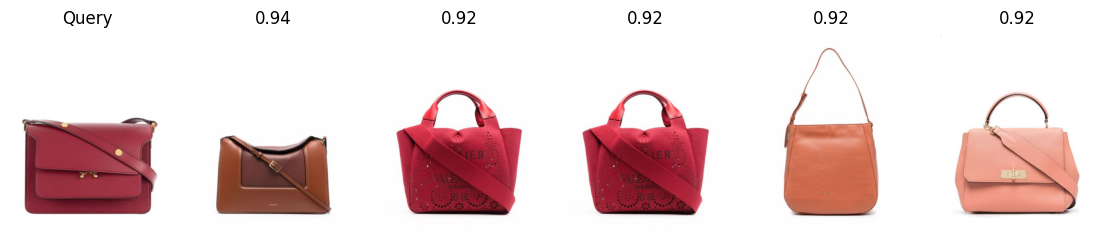

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity


query_image_path = "/content/drive/MyDrive/fashion/women/bags/wbag10041.png"


q_img = Image.open(query_image_path).convert("RGB")
q_tensor = transform(q_img).unsqueeze(0).to(device)


model.eval()
with torch.no_grad():
    q_emb = model(q_tensor).cpu().numpy()


similarities = cosine_similarity(q_emb, embeddings)[0]
top5_idx = similarities.argsort()[::-1][1:6]


plt.figure(figsize=(14,4))

plt.subplot(1,6,1)
plt.imshow(q_img)
plt.title("Query")
plt.axis("off")

for i, idx in enumerate(top5_idx):
    plt.subplot(1,6,i+2)
    plt.imshow(Image.open(image_paths[idx]))
    plt.title(f"{similarities[idx]:.2f}")
    plt.axis("off")

plt.show()


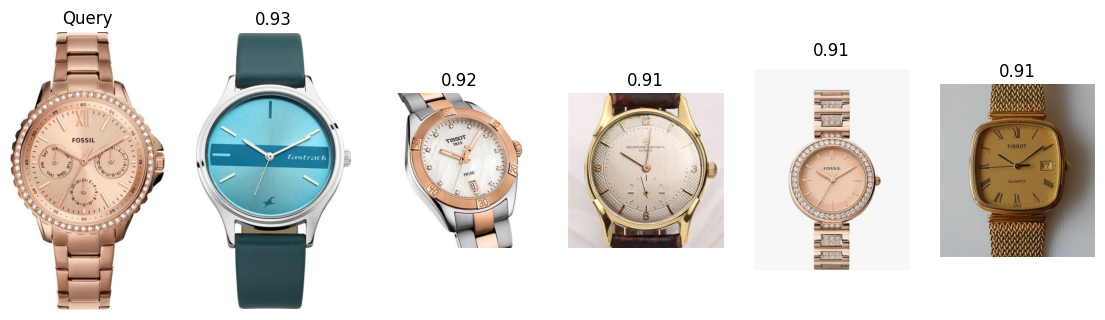

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity


query_image_path = "/content/drive/MyDrive/fashion/women/watches/FOSSIL_276.jpeg"


q_img = Image.open(query_image_path).convert("RGB")
q_tensor = transform(q_img).unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    q_emb = model(q_tensor).cpu().numpy()


similarities = cosine_similarity(q_emb, embeddings)[0]
top5_idx = similarities.argsort()[::-1][1:6]


plt.figure(figsize=(14,4))

plt.subplot(1,6,1)
plt.imshow(q_img)
plt.title("Query")
plt.axis("off")

for i, idx in enumerate(top5_idx):
    plt.subplot(1,6,i+2)
    plt.imshow(Image.open(image_paths[idx]))
    plt.title(f"{similarities[idx]:.2f}")
    plt.axis("off")

plt.show()


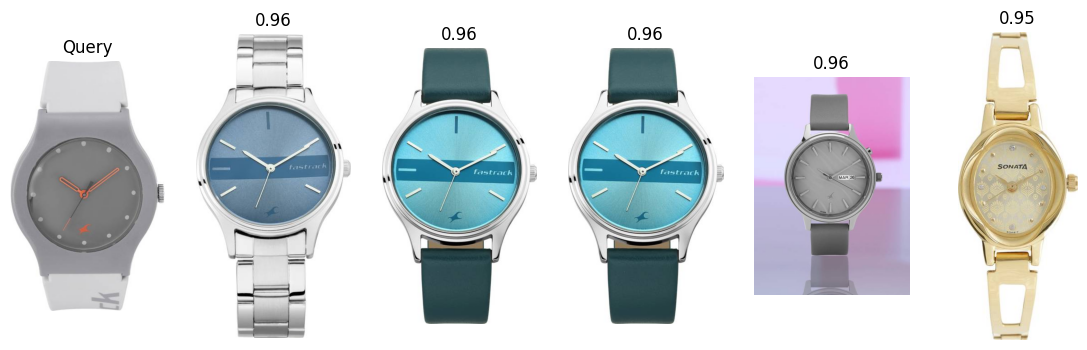

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity


query_image_path = "/content/drive/MyDrive/fashion/women/watches/Fastrack_909.jpeg"


q_img = Image.open(query_image_path).convert("RGB")
q_tensor = transform(q_img).unsqueeze(0).to(device)


model.eval()
with torch.no_grad():
    q_emb = model(q_tensor).cpu().numpy()


similarities = cosine_similarity(q_emb, embeddings)[0]
top5_idx = similarities.argsort()[::-1][1:6]


plt.figure(figsize=(14,4))

plt.subplot(1,6,1)
plt.imshow(q_img)
plt.title("Query")
plt.axis("off")

for i, idx in enumerate(top5_idx):
    plt.subplot(1,6,i+2)
    plt.imshow(Image.open(image_paths[idx]))
    plt.title(f"{similarities[idx]:.2f}")
    plt.axis("off")

plt.show()


In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/Aadhar/triplet_model.pth")
print("Model saved")


Model saved


In [ ]:
with open("/content/drive/MyDrive/Aadhar/image_paths.txt", "w") as f:
    for p in image_paths:
        f.write(p + "\n")

print("image_paths.txt saved in Drive")


image_paths.txt saved in Drive


In [ ]:
pip install streamlit


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 108.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 106.0 MB/s eta 0:00:00


In [ ]:
%%writefile /content/drive/MyDrive/Aadhar/app.py
import streamlit as st
import torch
import numpy as np
from PIL import Image
from torchvision import models, transforms
import torch.nn as nn
from sklearn.metrics.pairwise import cosine_similarity

# ---------------- PATHS ----------------
BASE_PATH = "/content/drive/MyDrive/Aadhar"
MODEL_PATH = f"{BASE_PATH}/triplet_model.pth"
EMB_PATH = f"{BASE_PATH}/image_embeddings.npy"
PATHS_FILE = f"{BASE_PATH}/image_paths.txt"

# ---------------- MODEL ----------------
class EmbeddingNet(nn.Module):
    def __init__(self):
        super().__init__()
        base = models.mobilenet_v2(weights="IMAGENET1K_V1")
        self.backbone = base.features
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(1280, 128)

    def forward(self, x):
        x = self


Writing /content/drive/MyDrive/Aadhar/app.py


In [ ]:
!ls /content/drive/MyDrive/Aadhar


 110146678025.pdf		      'Document from Bhadrika ^-^ (3).pdf'
 714023149012.jpg		      'Document from Bhadrika ^-^.pdf'
'aadhar card.pdf'		       image_embeddings.npy
 app.py				       image_paths.txt
 copyright.pdf			       SmartCityDashboard.pdf
'Document from Bhadrika ^-^ (1).pdf'   triplet_model.pth
'Document from Bhadrika ^-^ (2).pdf'


In [ ]:
!pip install streamlit pyngrok
!streamlit run /content/drive/MyDrive/Aadhar/app.py &>/content/logs.txt &
